# Building a Personalized Joke Recommendation System 


## Table of Contents

1. [Introduction](#introduction)<br>
1.1. [Business Question](#Business-Question)<br>
1.2. [Sub Questions](#Sub-Questions)
2. [Data Preprocessing](#data-preprocessing)<br>
2.1. [Explatory Data Analysis](#Explatory-Data-Analysis)<br>
3. [Model Training and Evaluation](#model-training-and-evaluation)<br>
3.1. [Manual KNN](#Manual-KNN)<br>
3.1.1. [Predicting a rating and evaluating the predicted rating](#Predicting-a-rating-and-evaluating-the-predicted-rating)<br>
3.1.2. [Recommending Jokes based on the user similarites](#Recommending-Jokes-based-on-the-user-similarites)<br>
3.1.3. [Recommending Jokes based on the item similarites](#Recommending-Jokes-based-on-the-item-similarites)<br>
3.2. [KNN With Surprise Package](#KNN-With-Surprise-Package)<br>
3.2.1. [Hyperparameter tuning for user-user similarity](#Hyperparameter-tuning-for-user-user-similarity)<br>
3.2.1.1. [Recommending jokes with Surprise package for user-user similarity](#Recommending-jokes-with-Surprise-package-for-user-user-similarity)<br>
3.2.1.2. [Computing item-item similarity with Surprise with KNN](#Computing-item-item-similarity-with-Surprise-with-KNN)<br>
3.3. [Manual-SVD](#Manual-SVD)<br>
3.3.1. [Recommending  with SVD based on the user similarites](#Recommending-with-SVD-based-on-the-user-similarites)<br>
3.3.2. [Predicting the RMSE with SVD](#Predicting-the-RMSE-with-SVD)<br>
3.3.2.1. [Recommending jokes with Surprise package for item-item similarity](#Recommending-jokes-with-Surprise-package-for-item-item-similarity)<br>
3.4. [Recommendation system using SVD from Suprise package](#Recommendation-system-using-SVD-from-Suprise-package)<br>
3.4.1. [Hyperparameter tuning for user-user similarity with SVD](#Hyperparameter-tuning-for-user-user-similarity-with-SVD)<br>
3.4.1.1. [Recommending  with SVD based on the user similarites using suprise package](#Recommending-with-SVD-based-on-the-user-similarites-using-suprise-package)<br>
3.4.2. [Hyperparameter tuning for user-user similarity with SVD from suprise package](#Hyperparameter-tuning-for-user-user-similarity-with-SVD-from-suprise-package)<br>
3.4.2.1. [Recommending  with SVD based on the item similarites using suprise package](#Recommending-with-SVD-based-on-the-user-similarites-using-suprise-package)<br>
3.4.2.2. [Hyperparameter tuning for item-item similarity with SVD](#Hyperparameter-tuning-for-item-item-similarity-with-SVD)<br>
3.4.2.3. [Recommending jokes with Surprise package for item-item similarity](#Recommending-jokes-with-Surprise-package-for-item-item-similarity)<br>
## [Introduction](#introduction)

In this project, we aim to build a recommendation system for using user ratings to provide personalized joke recommendations. To achieve this, we will use the Jester dataset.

## [Business Question](#Business-Question)

How can we use user ratings to develop a personalized joke recommendation system and recommend jokes to the user?

## [Sub Questions](#Sub-Questions)

What is the distribution of ratings among the available jokes?

what is the distribution of ratings among the available users?

Can we identify patterns in the ratings?

How can we use KNN and SVD algorithms to build personalized recommendation systems for each user based on their past ratings?

What is the distribution of number of ratings per user and joke?

How can we use the trained model to generate personalized joke recommendations for each user?

How can we improve the accuracy of the predictions, and can we incorporate additional data?

What models can we use for building a recommendation system, and how can we evaluate their performance?





## [Data Preprocessing](#data-preprocessing)<br>

The dataset we will be using is the jester dataset.
In the data preprocessing phase, we will explore and clean the data, removing any duplicates or missing values, and prepare it for use in our recommendation system. We will Also use the SVD method to reduce the dimensionality of our dataset for better ram usage.




In [1]:
# Importing the required libraries
import pandas as pd 
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import svd
from scipy.sparse.linalg import svds
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

import gc 


In [2]:
# Reading the data and set the column names so that it will all be in lower case  
df_items = pd.read_csv("jester_items.csv")
df_ratings = pd.read_csv("jester_ratings.csv")
df_items.columns=df_items.columns.str.lower()
df_ratings.columns = df_ratings.columns.str.lower()
df_ratings1=df_ratings


In [3]:
# Finding how many users and jokes are uniques in the dataset
print(df_ratings.userid.nunique())
print(df_ratings.jokeid.nunique())

59132
140


we have 59132 unique user id and 140 unique joke id. As there are a lot of rows in our data set we will filter the data so that it only has ratings for users and joke ids that have more than 10 pair in our dataframe.

In [4]:

# Count the number of ratings for each user
user_counts = df_ratings['userid'].value_counts()
joke_counts = df_ratings['jokeid'].value_counts()

# Filter the dataframe to keep only users with more than 10 ratings
df_ratings = df_ratings[df_ratings['userid'].isin(user_counts[user_counts > 100].index)]
df_ratings = df_ratings[df_ratings['jokeid'].isin(joke_counts[joke_counts > 100].index)]



In [5]:
df_ratings.describe()

,userid,jokeid,rating
count,518568.000000,518568.000000,518568.000000
mean,33628.225754,82.431222,1.786435
std,18977.125615,40.555481,5.217799
min,10.000000,5.000000,-10.000000
25%,16874.000000,47.000000,-1.594000
50%,37317.000000,84.000000,2.281000
75%,48337.000000,118.000000,5.812000
max,63978.000000,150.000000,10.000000


In [6]:
# Shwoing the first 5 rows 
df_ratings.head()

,userid,jokeid,rating
386,10,5,-5.750
387,10,7,0.281
388,10,8,0.781
389,10,13,8.281
390,10,15,3.594


In [7]:
# Checking the data type of the columns
df_ratings.dtypes

userid      int64
jokeid      int64
rating    float64
dtype: object

Missing values are a problem in any dataset. we will look for them and remove them if it is not a significant number. we can also impute them using various methods. Let's check if there are any missing values:


In [8]:
# Just to make sure that all Nan containing rows are deleted
print("No of NaN values in our dataframe: ", sum(df_ratings.isnull().any()))


No of NaN values in our dataframe:  0


as shown above, there is no missing values in our dataframe.

Duplicates in a dataframe is also another problem. We will look for these and remove them if we encounter any.

In [9]:
# Remove duplicates
df_ratings.drop_duplicates(inplace=True)

we will find the global mean of rating for jokes as we will use this in our model later (for evaluation of the predicted and actual ratings)

In [10]:
gmean = df_ratings.rating.mean()
print(" The Global mean rating of the jokes is {}".format(gmean))

 The Global mean rating of the jokes is 1.7864351791857576


## [Explatory Data Analysis](#Explatory-Data-Analysis)<br>


Let's calculate some basic statistics for the 'Rating' column:


In [11]:
print(df_ratings['rating'].describe())


count    518568.000000
mean          1.786435
std           5.217799
min         -10.000000
25%          -1.594000
50%           2.281000
75%           5.812000
max          10.000000
Name: rating, dtype: float64


we can see that the mean and median are very close to each other.

Let's plot the distribution of ratings:


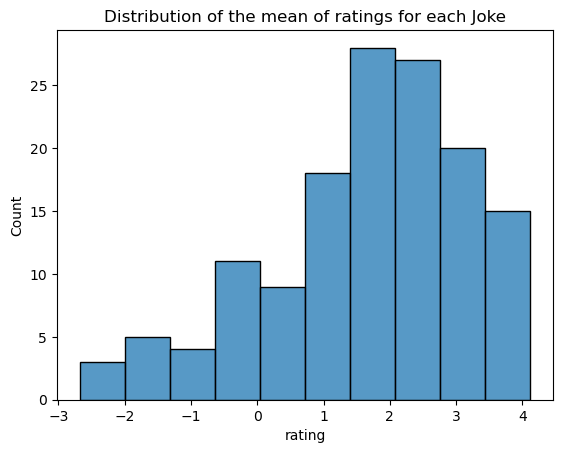

In [12]:
# Group the ratings by joke ID and compute the mean rating for each joke
Jokes_ratings = df_ratings.groupby('jokeid')['rating'].mean().reset_index()

# Create a histogram plot of the mean ratings
sns.histplot(Jokes_ratings['rating'])

# Set the title, x-axis label, and y-axis label for the plot
plt.title('Distribution of the mean of ratings for each Joke')
plt.xlabel('rating')
plt.ylabel('Count')

# Display the plot
plt.show()


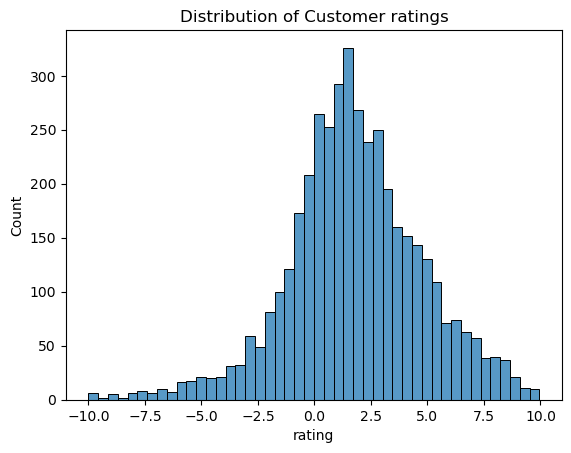

In [13]:
# Group the ratings by user ID and compute the mean rating for each user
joke_ratings = df_ratings.groupby('userid')['rating'].mean().reset_index()

# Create a histogram plot of the user ratings
sns.histplot(joke_ratings['rating'])

# Set the title, x-axis label, and y-axis label for the plot
plt.title('Distribution of Customer ratings')
plt.xlabel('rating')
plt.ylabel('Count')

# Display the plot
plt.show()


we can see that the distribution is normal

Let's calculate the average rating for each joke:


In [14]:
# Calculate the mean rating for each joke by grouping the ratings data frame by joke ID
joke_ratings = df_ratings.groupby('jokeid')['rating'].mean().reset_index()

# Display the first few rows of the resulting data frame
print(joke_ratings.head())


   jokeid    rating
0       5 -1.428267
1       7 -1.705285
2       8 -0.035420
3      13 -0.336909
4      15 -1.141562


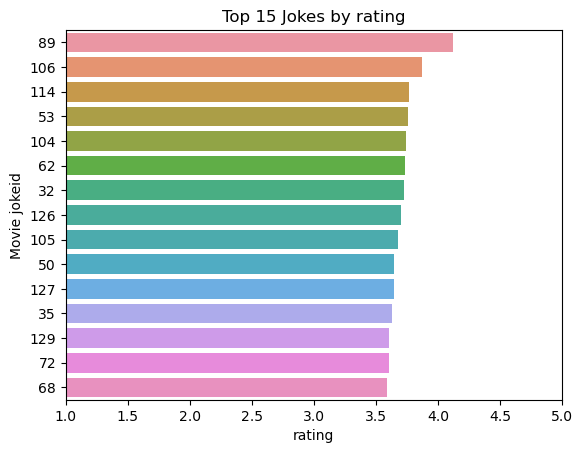

In [15]:
# Group the DataFrame by joke jokeid and calculate the mean rating for each joke
joke_ratings = df_ratings.groupby('jokeid')[['rating']].mean().sort_values(by="rating",ascending=False)

# Select the top 15 jokes by rating
top_joke = joke_ratings.head(15)

# Create a bar plot with jokeids on the y-axis and mean ratings on the x-axis
sns.barplot(x='rating', y=top_joke.index, data=top_jokes, orient='h', order=top_jokes.index)

# Set the plot jokeid, x-axis label, and y-axis label
plt.title('Top 15 Jokes by rating')
plt.xlabel('rating')
plt.ylabel('jokeid')

# Set the x-axis limits to show 1-5
plt.xlim(1, 5)

# Display the plot
plt.show()

del joke_ratings
del top_jokes


it seems that joke 89 has the highest average rating in our dataset. we will print this joke to see what it is.

In [16]:
# Select the row in the DataFrame where jokeid equals 89 and retrieve the joketext
joke_text = df_items.loc[df_items['jokeid'] == 89, 'joketext'].item()

# Print the joke text
print(joke_text)


A radio conversation of a US naval 
ship with Canadian authorities ... 

Americans: Please divert your course 15 degrees to the North to avoid a
collision.

Canadians: Recommend you divert YOUR course 15 degrees to the South to 
avoid a collision.

Americans: This is the Captain of a US Navy ship.  I say again, divert 
YOUR course.

Canadians: No.  I say again, you divert YOUR course.

Americans: This is the aircraft carrier USS LINCOLN, the second largest ship in the United States' Atlantic Fleet. We are accompanied by three destroyers, three cruisers and numerous support vessels. I demand that you change your course 15 degrees north, that's ONE FIVE DEGREES NORTH, or counter-measures will be undertaken to ensure the safety of this ship.

Canadians: This is a lighthouse.  Your call.



;)

In [17]:
# Group the 'df_ratings1' DataFrame by 'userid' and count the number of ratings for each user
no_of_rated_jokes_per_user = df_ratings1.groupby(by='userid')['rating'].count().sort_values(ascending=False)

# Print the head of the resulting Series, which shows the number of ratings for the top-rated users
no_of_rated_jokes_per_user.head()


userid
701    140
476    140
304    140
477    140
227    140
Name: rating, dtype: int64

C:\Users\98901\AppData\Local\Temp\ipykernel_21172\1221539091.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_of_rated_jokes_per_user, shade=True, ax=ax1)
C:\Users\98901\AppData\Local\Temp\ipykernel_21172\1221539091.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_of_rated_jokes_per_user, shade=True, cumulative=True,ax=ax2)


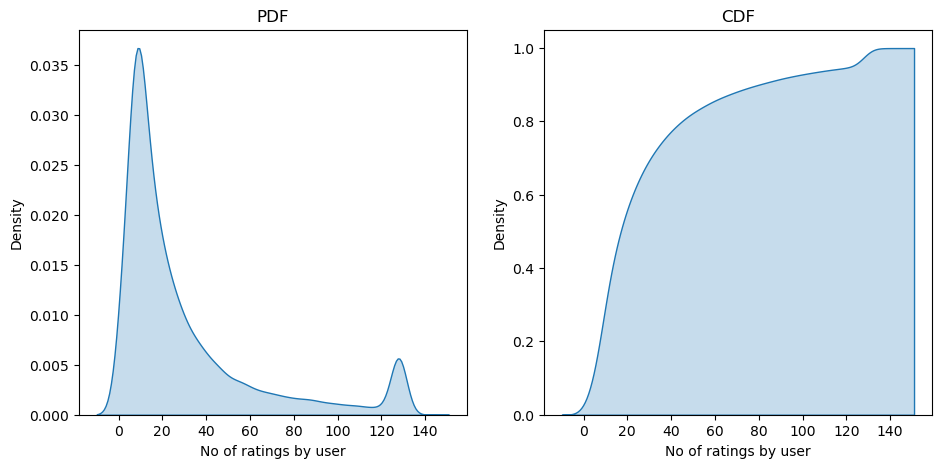

In [18]:
# Source https://www.kaggle.com/code/laowingkin/netflix-movi-recommendation

# Create a new figure with a size of (11, 5) using 'plt.figure()'
fig = plt.figure(figsize=(11, 5))

# Add the first subplot to the figure using 'plt.subplot()', and assign it to 'ax1'
ax1 = plt.subplot(121)

# Create a kernel density plot of the 'no_of_rated_jokes_per_user' data using 'sns.kdeplot()',
# with shading enabled and the plot drawn on 'ax1'
sns.kdeplot(no_of_rated_jokes_per_user, shade=True, ax=ax1)

# Set the x-axis label of 'ax1' to 'No of ratings by user'
plt.xlabel('No of ratings by user')

# Set the title of 'ax1' to 'PDF'
plt.title("PDF")

# Add the second subplot to the figure using 'plt.subplot()', and assign it to 'ax2'
ax2 = plt.subplot(122)

# Create a kernel density plot of the 'no_of_rated_jokes_per_user' data using 'sns.kdeplot()',
# with shading and cumulative distribution enabled, and the plot drawn on 'ax2'
sns.kdeplot(no_of_rated_jokes_per_user, shade=True, cumulative=True, ax=ax2)

# Set the x-axis label of 'ax2' to 'No of ratings by user'
plt.xlabel('No of ratings by user')

# Set the title of 'ax2' to 'CDF'
plt.title('CDF')

# Display the figure
plt.show()


In [19]:
no_of_rated_jokes_per_user.describe()


count    59132.000000
mean        29.788253
std         32.801761
min          1.000000
25%          8.000000
50%         16.000000
75%         36.000000
max        140.000000
Name: rating, dtype: float64

- There is something interesting going on with the quantiles here, as we can see from the above numbers.
- We observed that there was a huge upsurge from the 75% quantile range to the 100% quantile range.

we can see that the number of ratings by users goes down after 20 and it is less than 

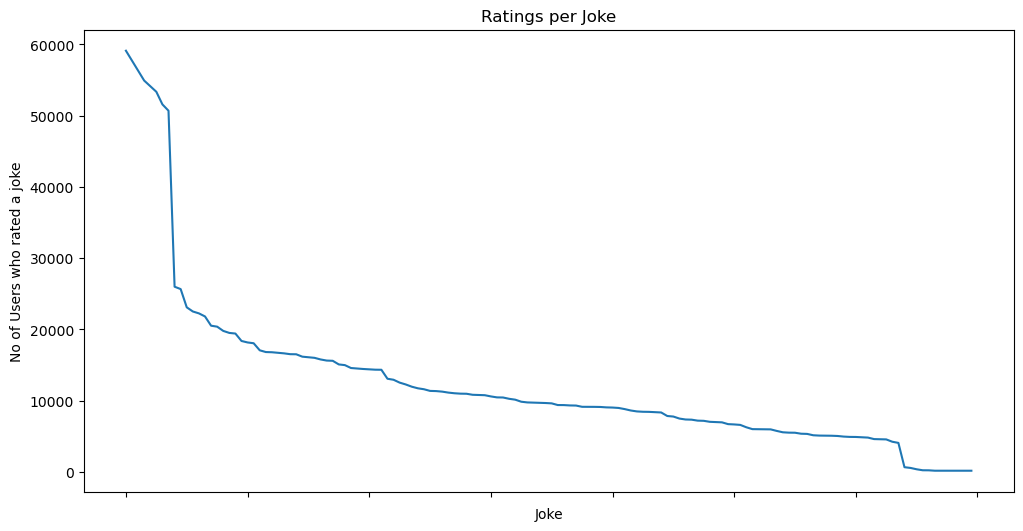

In [20]:
# Source https://www.kaggle.com/code/laowingkin/netflix-movi-recommendation

# Group the ratings DataFrame by jokeid and count the number of ratings for each joke
no_of_ratings_per_joke = df_ratings1.groupby(by='jokeid')['rating'].count().sort_values(ascending=False)

# Create a new figure with a size of 12x6 inches
fig = plt.figure(figsize = (12, 6))

# Get the current axis and plot the number of ratings for each joke
ax = plt.gca()
plt.plot(no_of_ratings_per_joke.values)

# Set the plot title, x-axis label, y-axis label, and remove the x-axis tick labels
plt.title('Ratings per Joke')
plt.xlabel('Joke')
plt.ylabel('No of Users who rated a joke')
ax.set_xticklabels([])

# Display the plot
plt.show()

# Remove variables from memory
del no_of_ratings_per_joke
del df_ratings1
del no_of_rated_jokes_per_user


- It is very skewed, just like the number of ratings given per user.
- There are some jokes (which are very popular) which are rated by huge number of users.
- But most of the jokes got a low amount of ratings.

## [Model Training and Evaluation](#model-training-and-evaluation)
In the model training and evaluation phase, we will explore 2 models KNN and SVD for building a recommendation system, which is a collaborative filtering. We will evaluate the performance of these models using metrics such as RMSE and select the best-performing model.



Becasue of time constraints and having a low memeoru capacity og 8 Gb, I used a sample of 10k rows so that the calculations could be done.

In [21]:
df_ratings_sample = df_ratings.sample(n=10000, random_state=420).copy() 


In [22]:
df_ratings.describe()

,userid,jokeid,rating
count,10000.000000,10000.000000,10000.000000
mean,33361.626700,82.929600,1.726547
std,19066.461317,40.770924,5.179222
min,10.000000,5.000000,-10.000000
25%,16326.000000,47.000000,-1.562000
50%,37193.000000,85.000000,2.219000
75%,48071.000000,119.000000,5.688000
max,63950.000000,150.000000,10.000000


We can see that our sample is a subset of our original data. the range of ratings are the same from -10 to 10. Also the mean rating is very close to the global mean rating with a difference of 0.08

Splitting the data into train, validation and test 

In [23]:
# Import the train_test_split function from the sklearn library
from sklearn.model_selection import train_test_split

# Split the original dataframe into training, validation and test sets using train_test_split
# 20% of the data will be used for testing, 20% for validation and 60% for training
# The random_state parameter is set to 420 to ensure reproducibility
df_train_val, df_test = train_test_split(df_ratings, test_size=0.2, random_state=420)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=420)


In [24]:
# Importing the necessary libraries
from scipy.sparse import csr_matrix

#Creating a pivot table with userid as index, jokeid as columns, and rating as values. Missing values are filled with 0.
df_mat = df_ratings.pivot_table(index='userid',columns='jokeid',values='rating').fillna(0)

# Converting the pivot table to a sparse matrix format
spars_df = csr_matrix(df_mat)

# Creating a sparse matrix for training data using pivot table
train_mat = df_train.pivot_table(index='userid',columns='jokeid',values='rating').fillna(0)
spars_train = csr_matrix(train_mat)

# Creating a sparse matrix for validation data using pivot table
val_mat = df_val.pivot_table(index='userid',columns='jokeid',values='rating').fillna(0)
spars_val = csr_matrix(train_mat)

# Creating a sparse matrix for testing data using pivot table
test_mat = df_test.pivot_table(index='userid',columns='jokeid',values='rating').fillna(0)
spars_test = csr_matrix(train_mat)

we have created sparse matrixes to store our dataframe in a more optimized method to use less RAM. 

In [25]:
## Sparsity
sparsity = 1.0 - (spars_train.nnz / float(spars_train.shape[0] * spars_train.shape[1]))
print("Sparsity of the train data is ", sparsity)

sparsity = 1.0 - (spars_val.nnz / float(spars_val.shape[0] * spars_val.shape[1]))
print("Sparsity of the Validation data is ", sparsity)

sparsity = 1.0 - (spars_test.nnz / float(spars_test.shape[0] * spars_test.shape[1]))
print("Sparsity of the Test data is ", sparsity)


Sparsity of the train data is  0.9863815176114787
Sparsity of the Validation data is  0.9863815176114787
Sparsity of the Test data is  0.9863815176114787


we can see that the sparcity of our matrixes is very high more than 99 percent whihc means that only 1.4 percent of our dataframe is filled with actual ratings.

### [Manual KNN](#Manual-KNN)

In this section we will develop a K nearest neighbour method to find the similar users and jokes and then based on this similarity, recommend jokes to the user.

In [26]:
df_mat.describe()

jokeid,5,7,8,13,15,16,17,18,19,20,...,141,142,143,144,145,146,147,148,149,150
count,3839.000000,3839.000000,3839.000000,3839.000000,3839.000000,3839.000000,3839.000000,3839.000000,3839.000000,3839.000000,...,3839.000000,3839.000000,3839.000000,3839.000000,3839.000000,3839.000000,3839.000000,3839.000000,3839.000000,3839.000000
mean,0.001913,-0.021473,-0.020073,-0.018251,0.000554,-0.046221,0.002507,0.007545,0.019993,-0.000277,...,-0.050493,0.024552,0.050308,0.073424,0.025691,-0.008587,0.042630,0.082167,0.053471,0.083143
std,0.102395,0.864580,0.696458,0.784777,0.722472,0.810662,0.814965,0.685143,0.733490,0.079423,...,0.818517,0.775544,0.758791,1.010334,0.685200,0.630430,0.807696,0.861788,0.750644,0.813988
min,-0.125000,-9.875000,-9.812000,-9.875000,-9.406000,-10.000000,-10.000000,-10.000000,-9.906000,-3.438000,...,-9.906000,-9.812000,-9.562000,-10.000000,-8.562000,-9.844000,-9.969000,-9.594000,-8.500000,-7.344000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.219000,9.938000,8.000000,10.000000,9.656000,9.875000,9.969000,9.375000,9.969000,3.375000,...,9.375000,9.969000,9.719000,10.000000,9.812000,9.438000,9.719000,10.000000,9.969000,9.906000


This is our dataframe with userids on the rows and jokeids on the columns. if the user has not rated the joke, it has been filled with a 0 rating for that joke by the user. Next, we will calculate our similarity matrix. we will use the cosine similarity matrix from the sklearn package and then sort them based on their similarity and select the k neighbours that we want to select for that user. this parameter k is a hytper parametere.
By specifying a userid in this function, we can get the k most similar users back.

In [27]:
# Defining the user-user matrix similarity
userids, cols, data = [], [], [] #initialize three lists to store the userids, columns, and data values.

userid = 3 #set the target user id.
jokeid = 5 #set the target joke id.
neighbours = 5 #set the number of neighbours to consider for similarity computation.

sim = cosine_similarity(spars_train.getrow(userid), spars_train).ravel() #compute the cosine similarity between the target user and all other users, and get a 1D array.
neighbours_sim_ind = sim.argsort()[-neighbours:] #get the indices of the 'neighbours' most similar users.
neighbours_sim_val = sim[neighbours_sim_ind] #get the similarity values of the 'neighbours' most similar users.

userids.extend([userid]*neighbours) #add 'userid' to the userids list 'neighbours' times.
cols.extend(neighbours_sim_ind) #add the indices of the 'neighbours' most similar users to the cols list.
data.extend(neighbours_sim_val) #add the similarity values of the 'neighbours' most similar users to the data list.

This function, get_top_neighbours(), takes a user_id, a sparse matrix spars_train, and a number of neighbours as input. It calculates the cosine similarity between the user's row and all other rows in the spars_train matrix, and then returns the indices of the neighbours most similar users to the input user. It does this by sorting the similarity scores in descending order, taking the indices of the top neighbours scores, and returning those indices as a list.

In [28]:

def get_top_neighbours(user_id, spars_train=spars_train, neighbours=5):
    # Compute the cosine similarity between the user's row and all other rows in the matrix
    sim = cosine_similarity(spars_train.getrow(user_id), spars_train).ravel()
    userids, cols, data = list(), list(), list()

    # Get similarity scores for all users
    sim = cosine_similarity(spars_train.getrow(userid), spars_train).ravel()

    # Find neighbours who have rated the target joke
    neighbours_sim_ind = sim.argsort()[-neighbours:]
    neighbours_sim_val = sim[neighbours_sim_ind]
    cols.extend(neighbours_sim_ind)

    return cols


For example for user with an id of 15, if we want to selcte the top 5 similar users, we have:

In [29]:
id=7
k=5
neighbour_indices = get_top_neighbours(id, neighbours=k)
print ("The top {} similar users to user {} are \n".format(k,id))
print(neighbour_indices)


The top 5 similar users to user 7 are 

[1448, 2066, 3, 119, 2235]


#### Function Overview:
The predict_rating function is designed to predict the rating that a user would give to a specific joke, based on the user's previous ratings of other jokes and the ratings given by other users to the target joke. The function uses a collaborative filtering algorithm that calculates the similarity between users and finds the most similar users to the target user. The function then calculates the predicted rating using a weighted average of the ratings given by the most similar users and the overall average rating for all users.
#### Input Parameters
The predict_rating function takes the following input parameters:<br>
- user_id_in: The ID of the target user for whom the rating is being predicted.
- joke_id: The ID of the target joke for which the rating is being predicted.
- spars_train (optional): The sparse matrix that contains the training data for the collaborative filtering algorithm. This matrix is used to calculate the similarity between users.
- df_ratings (optional): The DataFrame that contains the rating data for all users and all jokes.
- neighbours (optional): The number of most similar users to consider when calculating the predicted rating. The default value is 300.<br>
(I found that increasing the number of neighbours can make better predictions hence the high number of neighbours)
- weight (optional): The weight to assign to the ratings given by the most similar users. The default value is 0.5. <br> 
- if the weight is higher than 0.5 -> The ratings of similar users have more effect on the predicted outcome compared to the average of ratings
 - if the weight is lower than 0.5 -> The ratings of similar users have less effect on the predicted outcome compared to the average of ratings

#### Output
The predict_rating function prints the following output to the console:<br> 
- Actual rating: The actual rating given by the target user to the target joke (if available).
- Predicted rating: The predicted rating calculated by the function. the function takes the average of ratings the most similar users have given.
- MAE: The mean absolute error between the actual and predicted ratings.
- RMSE: The root mean squared error between the actual and predicted ratings.
#### Algorithm Overview
The predict_rating function uses the following algorithm to predict the rating:

- Get the actual rating given by the target user to the target joke (if available). If no actual rating is available, use the overall average rating for all users and all jokes.
- Get the overall average rating for all users and all jokes.
- Get the row index corresponding to the target user in the sparse matrix.
- Calculate the similarity scores between the target user and all other users in the sparse matrix.
- Find the neighbours users with the highest similarity scores.
- Get the ratings given by the neighbours users to the target joke (if available).
- Calculate the average rating given by the neighbours users to the target joke.
- Calculate the predicted rating using a weighted average of the ratings given by the neighbours users and the overall average rating.
- Calculate the mean absolute error and root mean squared error between the actual and predicted ratings.

In [30]:
def predict_rating(user_id_in, joke_id, spars_train=spars_df, df_ratings=df_ratings, neighbours=300, weight=0.5):
    unique_user_ids = {}
    user_count = 0
    for user_id in df_ratings['userid'].unique():
        unique_user_ids[user_id] = user_count
        user_count += 1
    # Get actual rating
    actual_rating = df_ratings[(df_ratings['userid'] == user_id_in) & (df_ratings['jokeid'] == joke_id)]['rating'].values
    if len(actual_rating) > 0:
        actual_rating = actual_rating[0]
    else:
        print("No actual rating found. Using the over all average rating")
        overall_avg_rating = df_ratings['rating'].mean()
        actual_rating = overall_avg_rating

    # Get overall average rating
    overall_avg_rating = df_ratings['rating'].mean()

    # Get row index corresponding to user ID
    user_index = unique_user_ids.get(user_id_in, None)
    if user_index is None:
        print("User ID not found")
        return
    row_index = spars_train.nonzero()[0][user_index]

    # Get similarity scores for all users
    sim = cosine_similarity(spars_train.getrow(row_index), spars_train).ravel()

    # Find neighbours with highest similarity scores
    neighbours_sim_ind = sim.argsort()[-neighbours:]
    neighbours_sim_val = sim[neighbours_sim_ind]

    # Find average rating for target joke among similar users
    similar_user_ratings = []
    for i in neighbours_sim_ind:
        rating = spars_train[i, joke_id]
        if rating != 0:
            similar_user_ratings.append(rating)
    if len(similar_user_ratings) > 0:
        similar_user_avg_rating = sum(similar_user_ratings) / len(similar_user_ratings)
    else:
        # Use overall average rating as default value
        similar_user_avg_rating = overall_avg_rating

    # Calculate predicted rating using weighted average
    predicted_rating = (similar_user_avg_rating * weight) + (overall_avg_rating * (1 - weight))
    prediction_error = actual_rating - predicted_rating

    mae = np.abs(prediction_error).mean()
    rmse = np.sqrt(np.mean(prediction_error**2))

    print("Actual rating: {}".format(actual_rating))
    print("Predicted rating: {}".format(predicted_rating))
    print("MAE: {}".format(mae))
    print("RMSE: {}".format(rmse))


In this section we will test some of the users and jokes to see evaluate our model and make sure everything works. 

In [31]:
predict_rating(10,34)

No actual rating found. Using the over all average rating
Actual rating: 1.7265466
Predicted rating: 2.2427733
MAE: 0.5162267
RMSE: 0.5162267


In [32]:
predict_rating(36675,34)

Actual rating: 4.406000000000001
Predicted rating: 3.0632733
MAE: 1.3427267000000005
RMSE: 1.3427267000000005


In [33]:
predict_rating(40713,78)

Actual rating: 1.375
Predicted rating: 2.3267733
MAE: 0.9517733000000002
RMSE: 0.9517733000000002


Overall, the function seems to be able to predict ratings with some degree of accuracy, but the errors can be relatively large. It is worth noting that the quality of the predictions can depend heavily on the number and quality of the ratings available for the given user and joke, as well as on the choice of parameters such as the number of neighbors and the weighting factor.

In [34]:
predict_rating(16,120)

No actual rating found. Using the over all average rating
Actual rating: 1.7265466
Predicted rating: 2.3925233
MAE: 0.6659767000000001
RMSE: 0.6659767000000001


#### [Recommending Jokes based on the user similarites](#Recommending-Jokes-based-on-the-user-similarites)<br>



in this section we will define a function which gets the userid of a user and then prints some recommendated jokes
#### Function Overview:<br>
The recommend_jokes function takes in a user ID and returns a list of the top K recommended jokes that the user has not rated yet. The function uses collaborative filtering to find the similarity between the target user and other users in the dataset, and then calculates the average rating for each unrated joke among the similar users. The function then sorts the jokes by their average rating and returns the top K jokes with their joke text and average rating.<br>

#### Input Parameters:<br>
- user_id_in: the ID of the target user for whom jokes will be recommended
- spars_train: the sparse matrix containing the user-item ratings for training the collaborative filtering algorithm (default is spars_df)
- df_ratings: the pandas dataframe containing the user-item ratings (default is df_ratings)
- df_items: the pandas dataframe containing the joke texts (default is df_items)
neighbours: the number of similar users to consider in the collaborative filtering algorithm (default is 300)
- top_k: the number of top recommended jokes to return (default is 5)
#### Output:<br>
The function returns a list of the top K recommended jokes for the target user, where each recommended joke is represented as a tuple of the form (joke_id, joke_text, avg_rating).

- joke_id: the ID of the recommended joke
- joke_text: the text of the recommended joke
- avg_rating: the average rating of the recommended joke among similar users<br>

#### Algorithm Overview:<br>
- First, the function creates a dictionary called unique_user_ids that maps each user ID to a unique index. It also creates a variable user_count that is initialized to 0.

- The function then loops through each unique user ID in the df_ratings DataFrame and adds the ID and its corresponding index (which is just user_count) to the unique_user_ids dictionary. It increments user_count after each iteration.

- Next, the function tries to find the row index in the spars_train sparse matrix that corresponds to the input user_id_in. It does this by getting the index of the user ID in the unique_user_ids dictionary and using that index to access the corresponding row in the spars_train matrix.

- The function then uses the cosine_similarity() function from scikit-learn's metrics.pairwise module to compute the cosine similarity between the input user and all other users in the spars_train matrix. It does this by passing the input user's row in spars_train and the entire spars_train matrix to cosine_similarity(), and then flattening the resulting similarity matrix using the ravel() method.

- After computing the similarity scores for all users, the function sorts them in descending order and selects the top neighbours users as the "neighbours" of the input user. These are the users whose ratings are most similar to the input user's ratings.

- Next, the function gets the ratings for the input user by accessing the corresponding row in the spars_train matrix and converting it to a dense array using the toarray() method.

- The function then finds the indices of all unrated jokes by using the np.where() function to find the indices of all elements in the user_ratings array that are equal to 0.

- For each unrated joke, the function finds the average rating for that joke among the "neighbours" of the input user. It does this by looping through each "neighbour" user and checking if they have rated the joke. If they have, their rating is added to a list of "similar user ratings" for that joke. After looping through all "neighbour" users, the function computes the average rating for the joke by dividing the sum of the "similar user ratings" by the number of ratings in the list.

- After computing the average ratings for all unrated jokes, the function sorts them in descending order and selects the top top_k jokes as the "recommended" jokes for the input user.

- Finally, the function returns a list of tuples, where each tuple contains the joke ID, joke text, and average rating for a recommended joke.

In [35]:
def recommend_jokes(user_id_in, spars_train=spars_df, df_ratings=df_ratings, df_items=df_items, neighbours=300, top_k=5):
    unique_user_ids = {}
    user_count = 0
    for user_id in df_ratings['userid'].unique():
        unique_user_ids[user_id] = user_count
        user_count += 1
    # Get row index corresponding to user ID
    user_index = unique_user_ids.get(user_id_in, None)
    if user_index is None:
        print("User ID not found")
        return
    row_index = spars_train.nonzero()[0][user_index]
    # Get similarity scores for all users
    sim = cosine_similarity(spars_train.getrow(row_index), spars_train).ravel()
    # Find neighbours with highest similarity scores
    neighbours_sim_ind = sim.argsort()[-neighbours:]
    # Get the ratings for the target user
    user_ratings = spars_train.getrow(row_index).toarray()[0]
    # Find the indices of unrated jokes
    unrated_jokes_ind = np.where(user_ratings == 0)[0]
    # Find the average rating for each joke among similar users
    avg_ratings = []
    for joke_id in unrated_jokes_ind:
        similar_user_ratings = []
        for i in neighbours_sim_ind:
            rating = spars_train[i, joke_id]
            if rating != 0:
                similar_user_ratings.append(rating)
        if len(similar_user_ratings) > 0:
            avg_rating = sum(similar_user_ratings) / len(similar_user_ratings)
            avg_ratings.append((joke_id, avg_rating))
    # Sort the jokes by average rating
    sorted_jokes = sorted(avg_ratings, key=lambda x: x[1], reverse=True)
    # Get the top K jokes and their joke text
    top_jokes = []
    for i in range(min(top_k, len(sorted_jokes))):
        joke_id, avg_rating = sorted_jokes[i]
        joke_text = df_items[df_items['jokeid'] == joke_id]['joketext'].values[0]
        top_jokes.append((joke_id, joke_text, avg_rating))
    return top_jokes


Now let's try to recommend some jokes to user with a userid of 16:

In [36]:
recommend_jokes(16)

[(109,
  'Do you believe in life after death? the boss asked one of his employees. "Yes, sir," the new recruit replied. "Well, then, that makes everything just fine..." the boss went on. "After you left early yesterday to go to your grandmother\'s funeral, she stopped in to see you."',
  6.836),
 (94,
  'Two atoms are walking down the street when one \natom says to the other \n"Oh, my! I\'ve lost an electron!"\n\nThe second atom says"Are you sure"\n\nThe first replies "I\'m positive!"\n',
  6.677166666666666),
 (42,
  'Two men are discussing the age old question: who enjoys sex more, the\nman or the woman?  A woman walks by and listens in for awhile and then\ninterrupts: \n"Listen you guys. You know when your ear itches and you put in your \nlittle finger and wiggle it around for awhile?  Afterward,\nwhich feels better, your finger or your ear?"\n',
  6.492000000000001),
 (105,
  'A couple of hunters are out in the woods in the deep south when one of them falls to the ground. He doesn\

#### [Recommending Jokes based on the item similarites](#Recommending-Jokes-based-on-the-item-similarites)<br>



In this section we focus on finding the similarities between jokeids instead of users. 

Function Overview:<br>
This function takes a joke id as input and returns a list of top k similar jokes for the given joke id. It uses cosine similarity to calculate similarity between the jokes and returns the joke text for each similar joke.

Input Parameters:<br>
- joke_id: The id of the joke for which we want to find similar jokes
- spars_df: The sparse matrix containing the user ratings for each joke. Default is set to spars_df.
- m_m_sim_sparse: The sparse matrix containing the cosine similarity between each pair of jokes. If None, the function will calculate it using the cosine_similarity function from the sklearn.metrics.pairwise module. Default is set to None.
- df_items: The dataframe containing the joke text for each joke id. Default is set to df_items.
- top_k: The number of similar jokes to return. Default is set to 10.<br>

Output:<br>
- The function returns a list of top k similar jokes for the given joke id. Each joke is represented as a tuple containing the joke id and the joke text.

Algorithm Overview:<br>
- If m_m_sim_sparse is None, calculate the cosine similarity matrix between the jokes using the cosine_similarity function from the sklearn.metrics.pairwise module.
Get the top k similar jokes for the given joke id using the argsort() function on the row of the joke in the cosine similarity matrix.
- For each similar joke, get the joke text using the df_items dataframe.
- Print the original joke and the number of ratings it has, as well as the number of jokes similar to it and the top k most similar jokes with their id and text.
- Return a list of top k similar jokes with their id and text.

Detailed Algorithm steps:

- If m_m_sim_sparse is None:
Calculate the cosine similarity matrix between the jokes using the cosine_similarity function from the sklearn.metrics.pairwise module.
- Get the top k similar jokes for the given joke id:
- Retrieve the row of the joke in the cosine similarity matrix using its id.
- Convert the row to a dense array using the toarray() method.
- Flatten the array using the ravel() method.
- Sort the flattened array in ascending order using the argsort() method.
- Reverse the sorted array using the [::-1] slicing operator.
- Ignore the first element of the reversed array (which is the original joke) using the [1:] slicing operator.
- Take the top k elements of the remaining array using the [:top_k] slicing operator.
For each similar joke:
- Retrieve the joke text using the df_items dataframe and the joke id.
- Append a tuple containing the joke id and text to the similar_jokes list.
- Print the original joke and the number of ratings it has, as well as the number of jokes similar to it and the top k most similar jokes with their id and text.
Return a list of top k similar jokes with their id and text.

In [37]:
def get_similar_jokes(joke_id, spars_df=spars_df, m_m_sim_sparse=None, df_items=df_items, top_k=10):
    if m_m_sim_sparse is None:
        m_m_sim_sparse = cosine_similarity(X=spars_df.T, dense_output=False)
# Get the top k similar jokes for the given joke id
    sim_jokes = m_m_sim_sparse[joke_id].toarray().ravel().argsort()[::-1][1:top_k+1]
# Get the joke text for each similar joke
    similar_jokes = []
    for j_id in sim_jokes:
        joke_text = df_items[df_items['jokeid'] == j_id]['joketext'].values[0]
        similar_jokes.append((j_id, joke_text))
    print("Joke - ", df_items.loc[joke_id].values[1])
    print("It has {} ratings from users.".format(spars_df[:,joke_id].getnnz()))
    print("We have {} Jokes which are similar to this and we will get top {} most similar jokes".format(m_m_sim_sparse[:,joke_id].getnnz(), 10))

    return similar_jokes

Finding similar jokes for the joke with an id of 67:

In [38]:
joke_id = 67
get_similar_jokes(joke_id)


Joke -  A man piloting a hot air balloon discovers he has wandered off course and
is hopelessly lost. He descends to a lower altitude and locates a man
down on the ground. He lowers the balloon further and shouts "Excuse me,
can you tell me where I am?"

The man below says: "Yes, you're in a hot air balloon, about 30 feet
above this field."

"You must work in Information Technology," says the balloonist.

"Yes I do," replies the man. "And how did you know that?"

"Well," says the balloonist, "what you told me is technically correct,
but of no use to anyone."

The man below says, "You must work in management."

"I do," replies the balloonist, "how did you know?"

"Well," says the man, "you don't know where you are, or where you're
going, but you expect my immediate help. You're in the same position you
were before we met, but now it's my fault!"


It has 80 ratings from users.
We have 103 Jokes which are similar to this and we will get top 10 most similar jokes


[(107,
  "(A) The Japanese eat very little fat and suffer fewer heart attacks than the British or Americans. (B) On the other hand, the French eat a lot of fat and also suffer fewer heart attacks than the British or Americans. (C) The Chinese drink very little red wine and suffer fewer heart attacks than the British or Americans. (D) The Italians drink excessive amounts of red wine and also suffer fewer heart attacks than the British or Americans. (E) Conclusion: Eat and drink what you like. It's speaking English that kills you."),
 (33,
  'What do you call an American in the finals of the world cup?\n\n"Hey Beer Man!"\n'),
 (52,
  'Q: What do Monica Lewinsky and Bob Dole have in common?\nA: They were both upset when Bill finished first.\n'),
 (74,
  'Q: How many stalkers does it take to change a light bulb?\n\nA: Two. One to replace the bulb, and the other to watch it day and night.\n'),
 (16, 'Q. What is orange and sounds like a parrot?  \n\nA. A carrot.\n'),
 (30,
  "Q: What's the d

## [KNN With Surprise Package](#KNN-With-Surprise-Package)<br>


The Surprise package in Python provides a powerful tool for building and evaluating recommender systems. One of the popular algorithms in this package is KNNWithMeans, which is a collaborative filtering technique that predicts the user-item rating matrix using the similarity between users or items.

To build a recommendation system using KNNWithMeans we follow these steps:<br>
- Load data into surprise dataset format using a reader object and the Dataset.load_from_file() method.
- Create a KNNWithMeans object with suitable hyperparameters, such as the number of nearest neighbors to consider and the similarity metric to use.
- Fit the model on the dataset using the fit() method.
- Generate personalized recommendations for new users based on their historical ratings using the fitted model.
- Evaluate the model using metrics such as RMSE or MAE to assess its performance.
- Finally, we can fit this model on our dataset using the fit() method and use it to generate personalized recommendations for new users based on their historical ratings. The model can also be evaluated using various metrics like RMSE or MAE to assess its performance.

Overall, KNNWithMeans is a simple yet effective approach to build personalized recommendation systems that can be easily implemented using the Surprise package in Python.

In [39]:
from surprise.model_selection import cross_validate
from surprise import Dataset, SVD, Reader, KNNWithMeans

reader = Reader(rating_scale=(-10,10))

data = Dataset.load_from_df(df_ratings[['userid', 'jokeid', 'rating']],reader)

# We'll use the famous KNN algorithm.

sim_options = {
    "name": "cosine",
    "user_based": True,  # compute  similarities between items
}
algo = KNNWithMeans(k=40,min_k=5,sim_options=sim_options)

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=3, verbose=True)

Computing the cosine similarity matrix...


c:\Users\98901\anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    5.3903  5.5004  5.4848  5.4585  0.0487  
MAE (testset)     3.9704  4.0405  4.0651  4.0254  0.0401  
Fit time          0.84    0.80    0.78    0.80    0.02    
Test time         0.20    0.19    0.19    0.19    0.01    


{'test_rmse': array([5.39028637, 5.50042893, 5.48478022]),
 'test_mae': array([3.9704374 , 4.040515  , 4.06512027]),
 'fit_time': (0.837188720703125, 0.799180269241333, 0.7775933742523193),
 'test_time': (0.20404648780822754, 0.1854872703552246, 0.1890428066253662)}

The above code uses the Surprise package in Python to perform collaborative filtering on a dataset of jokes ratings using KNNWithMeans algorithm.

First, the code imports necessary classes from the Surprise package. The Reader class is used to parse a file containing ratings data and the Dataset class is used to load the ratings data into a suitable format for Surprise.

The Reader class is instantiated with the range of rating scale (-10,10) and the Dataset class is used to load the ratings data from a Pandas DataFrame containing 'userid', 'jokeid', and 'rating' columns.

Next, the code defines the similarity metric as "cosine" and specifies that we want to compute user-based similarities. Then, an instance of the KNNWithMeans algorithm is created with k=40 (i.e., the number of nearest neighbors to consider) and min_k=5 (i.e., the minimum number of neighbors required for a prediction).

Finally, the code calls the cross_validate method with the KNNWithMeans algorithm, the loaded dataset, and the evaluation metric measures of "RMSE" and "MAE". The cross-validation is performed with 3 folds and the results are printed. This method evaluates the performance of the KNNWithMeans algorithm on the dataset using the specified evaluation metrics.

### [Hyperparameter tuning for user-user similarity](#Hyperparameter-tuning-for-user-user-similarity)<br>



This part performs hyperparameter tuning using grid search on a KNNWithMeans model in the Surprise package for building and evaluating recommender systems. The parameter grid includes the similarity metric type (msd or cosine), number of neighbors (k), minimum support, and user-based or item-based similarity computation. GridSearchCV function from Surprise is used to perform cross-validation with 3 folds to evaluate different parameter combinations for each metric. The measures used to evaluate the model are RMSE and MAE. After fitting the data, the best RMSE score and the combination of parameters that gave the best RMSE score are printed. This code can be used to optimize the performance of the KNNWithMeans algorithm for specific datasets and application requirements.





In [40]:
from surprise.model_selection import GridSearchCV
param_grid= {'name': ['cosine'],"k":{20,40,70,100,120},'min_support': [5, 10],'user_based': [True]}


# param_grid = {"name":"cosine","k":[5,10],"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)
# best RMSE score
print(gs.best_score["rmse"])
# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])
gc.collect()

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

24

This code uses the best_estimator attribute of the GridSearchCV object to retrieve the algorithm that yielded the best Root Mean Squared Error (RMSE) score during the hyperparameter tuning process. Then, it performs a 3-fold cross-validation using this algorithm and the data object, computing both RMSE and Mean Absolute Error (MAE) measures. The verbose parameter is set to True to print the results of each fold during the cross-validation.

In [41]:
# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator["rmse"]
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    5.6037  5.6116  5.6721  5.6291  0.0306  
MAE (testset)     4.2172  4.2393  4.2767  4.2444  0.0246  
Fit time          0.37    0.37    0.40    0.38    0.01    
Test time         0.19    0.13    0.17    0.16    0.02    


{'test_rmse': array([5.60365519, 5.61157429, 5.67207515]),
 'test_mae': array([4.2171818 , 4.23933569, 4.27673333]),
 'fit_time': (0.37008213996887207, 0.3740847110748291, 0.40009045600891113),
 'test_time': (0.18604302406311035, 0.13002896308898926, 0.17303872108459473)}

We get high error numbers since we dont have ratings for 99 percent of our pairs 

#### [Recommending jokes with Surprise package for user-user similarity](#Recommending-jokes-with-Surprise-package-for-user-user-similarity)<br>


The first function, get_top_n(predictions, n=10), takes a list of Prediction objects as input and returns the top-N recommendations for each user. The predictions list contains the estimated rating for each user-item pair, as returned by the test method of the algo object.

The second part of the code prepares the data for training and testing the model. The Reader object specifies the rating scale of the dataset. The Dataset object loads the df_ratings dataframe into a Surprise-compatible format. The trainset object is built from the entire dataset. The algo object is initialized with the hyperparameters that yielded the best RMSE score from the GridSearchCV method. The algo object is then fitted to the training set using the fit method.

The testset object is built from all the user-item pairs that are not in the training set. The algo.test method is used to make predictions for each user-item pair in the test set. The get_top_n function is then used to obtain the top-10 recommended items for each user.

Finally, the code prints the recommended items for each user. The output consists of the user ID and a list of recommended items, sorted by the estimated rating in descending order. The recommendation system is based on the ratings of similar users, so it provides personalized recommendations based on each user's past ratings and the ratings of other similar users.

In [42]:
from collections import defaultdict
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train a KNNwithMeans algorithm on the dataset.
reader = Reader(rating_scale=(-10,10))
data = Dataset.load_from_df(df_ratings[['userid', 'jokeid', 'rating']],reader)
trainset = data.build_full_trainset()
algo = algo = gs.best_estimator["rmse"]
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

gc.collect()

Computing the msd similarity matrix...
Done computing similarity matrix.
28434 [107, 53, 134, 48, 57, 114, 119, 137, 35, 110]
12809 [54, 132, 150, 83, 84, 148, 96, 126, 138, 48]
49136 [108, 126, 56, 129, 78, 69, 48, 138, 71, 115]
12428 [97, 53, 119, 106, 56, 132, 102, 112, 147, 8]
717 [56, 89, 53, 147, 48, 62, 81, 115, 57, 119]
54402 [148, 64, 36, 62, 127, 115, 122, 102, 97, 93]
51393 [53, 135, 29, 91, 114, 134, 125, 68, 44, 111]
191 [127, 115, 60, 50, 109, 96, 138, 132, 33, 148]
16875 [29, 49, 114, 70, 69, 112, 119, 91, 68, 131]
54911 [64, 36, 21, 130, 137, 72, 119, 89, 42, 114]
12867 [127, 138, 150, 41, 40, 48, 130, 110, 53, 99]
1279 [114, 89, 106, 29, 123, 118, 97, 117, 38, 133]
45179 [89, 49, 29, 112, 88, 54, 42, 96, 102, 127]
37090 [76, 138, 115, 5, 89, 106, 80, 53, 24, 90]
61914 [120, 92, 18, 87, 72, 134, 49, 32, 104, 80]
21323 [72, 55, 138, 80, 41, 62, 90, 37, 105, 20]
1992 [128, 49, 88, 95, 138, 80, 120, 142, 105, 106]
1987 [69, 130, 115, 19, 119, 30, 126, 82, 70, 110]
11646 [8

0

In the results you can see the top 10 similar jokes for each user

#### [Computing item-item similarity with Surprise with KNN](#Computing-item-item-similarity-with-Surprise-with-KNN)<br>




This code performs a grid search using the Surprise library's GridSearchCV function to find the best combination of hyperparameters for a KNNWithMeans collaborative filtering algorithm. The hyperparameters being searched over are name, k, min_support, and user_based. The measures argument specifies that both RMSE and MAE should be computed during the grid search. we will use a 3-fold cross validation.

After fitting the grid search on the data, the best RMSE score is printed, as well as the combination of hyperparameters that gave the best RMSE score. Finally, gc.collect() is called to perform garbage collection to free up memory.

In [43]:
from surprise.model_selection import GridSearchCV
param_grid= {'name': ['msd', 'cosine'],"k":{20,40,70,100,120},'min_support': [5, 10],'user_based': [False]}
# param_grid = {"name":"cosine","k":[5,10],"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)
# best RMSE score
print(gs.best_score["rmse"])
# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

gc.collect()

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

24

This code uses the best_estimator and cross_validate functions from the Surprise library to evaluate the performance of the algorithm that yielded the best RMSE score in the grid search.

best_estimator returns the algorithm that achieved the best score based on the input grid of parameters and evaluation metric. In this case, the algorithm is assigned to the algo variable.

cross_validate function is then used to evaluate the performance of the algorithm by performing a 3-fold cross-validation on the input data. The measures parameter specifies the evaluation metrics to use, which are RMSE (root mean squared error) and MAE (mean absolute error) in this case. The verbose parameter is set to True to display the results of each fold in addition to the overall results.

In [44]:
# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator["rmse"]
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    5.5598  5.4626  5.6537  5.5587  0.0780  
MAE (testset)     4.2527  4.1156  4.2393  4.2026  0.0617  
Fit time          0.40    0.32    0.34    0.35    0.03    
Test time         0.16    0.17    0.17    0.17    0.01    


{'test_rmse': array([5.5598437 , 5.46258203, 5.65366764]),
 'test_mae': array([4.25268984, 4.11562263, 4.23933928]),
 'fit_time': (0.39510035514831543, 0.3180713653564453, 0.3430774211883545),
 'test_time': (0.1610240936279297, 0.16603899002075195, 0.17403912544250488)}

in the above we can see the MAE and RMSE of the KNN model with means for predicting users ratings 

This code is creating a top-n recommendation system for each user using the KNNWithMeans algorithm.

First, the code imports the defaultdict from collections and defines the function get_top_n which takes a list of prediction objects and the number of recommendations to output for each user as inputs.

The get_top_n function maps the predictions to each user and returns a dictionary where the keys are the user ids and the values are a list of tuples that contains the raw item id and rating estimation of the recommended items. The list is sorted by rating estimation in descending order and is trimmed to the n highest recommendations.

Next, the code loads the dataset into a Surprise Dataset object and builds a full training set from it using the build_full_trainset() method. The KNNWithMeans algorithm is then trained on this training set using the fit() method.

The build_anti_testset() method is then used to get all pairs of (user, item) that are NOT in the training set, and the test() method of the trained algorithm is used to predict ratings for each of these pairs.

Finally, the get_top_n() function is used to get the top 10 recommendations for each user based on these predicted ratings. The recommended items are printed for each user. The gc.collect() function is used to free up memory.

In [45]:
from collections import defaultdict
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train a KNNwithMeans algorithm on the dataset.
reader = Reader(rating_scale=(-10,10))
data = Dataset.load_from_df(df_ratings[['userid', 'jokeid', 'rating']],reader)
trainset = data.build_full_trainset()
algo = algo = gs.best_estimator["rmse"]
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

gc.collect()

Computing the msd similarity matrix...
Done computing similarity matrix.
28434 [107, 53, 134, 48, 57, 114, 119, 137, 35, 110]
12809 [54, 132, 150, 83, 84, 148, 96, 126, 138, 48]
49136 [108, 126, 56, 129, 78, 69, 48, 138, 71, 115]
12428 [97, 53, 119, 106, 56, 132, 102, 112, 147, 8]
717 [56, 89, 53, 147, 48, 62, 81, 115, 57, 119]
54402 [148, 64, 36, 62, 127, 115, 122, 102, 97, 93]
51393 [53, 135, 29, 91, 114, 134, 125, 68, 44, 111]
191 [127, 115, 60, 50, 109, 96, 138, 132, 33, 148]
16875 [29, 49, 114, 70, 69, 112, 119, 91, 68, 131]
54911 [64, 36, 21, 130, 137, 72, 119, 89, 42, 114]
12867 [127, 138, 150, 41, 40, 48, 130, 110, 53, 99]
1279 [114, 89, 106, 29, 123, 118, 97, 117, 38, 133]
45179 [89, 49, 29, 112, 88, 54, 42, 96, 102, 127]
37090 [76, 138, 115, 5, 89, 106, 80, 53, 24, 90]
61914 [120, 92, 18, 87, 72, 134, 49, 32, 104, 80]
21323 [72, 55, 138, 80, 41, 62, 90, 37, 105, 20]
1992 [128, 49, 88, 95, 138, 80, 120, 142, 105, 106]
1987 [69, 130, 115, 19, 119, 30, 126, 82, 70, 110]
11646 [8

0

In the results you can see the top 10 similar jokeids for each joke

## [Manual SVD](#Manual-SVD)<br>




This code defines a function called "lowrank" that performs low-rank matrix approximation using the Singular Value Decomposition (SVD) technique. The function takes four input parameters: the left singular vectors (u), the singular values (s), the right singular vectors (vt), and the desired rank (k) of the low-rank approximation.

The function first selects the first k columns of the left singular vectors (uk) and the first k rows of the right singular vectors (vk) to create new matrices. It also creates a diagonal matrix (sk) that contains the first k singular values on its diagonal.

Next, the function performs matrix multiplication between the reduced left singular vectors, the diagonal matrix, and the reduced right singular vectors to create a low-rank approximation of the original matrix.

Finally, the function returns the low-rank approximation matrix.

The purpose of this function is to reduce the dimensionality of a matrix by approximating it with a lower-rank matrix. This can be useful for a variety of applications such as data compression, feature extraction, and noise reduction.

In [46]:
def lowrank(u,s,vt,k):
    uk=u[:,:k]
    sk=np.diag(s[:k])
    vk=vt[:k,:]
    return uk @ sk @ vk

This is a Python function called RMSE_rating that takes in four arguments:

- R_pred: a matrix of predicted ratings, where rows represent users and columns represent items (in this case, jokes).
- user_test: a 1D array of user IDs corresponding to the test set of ratings.
- jokes_test: a 1D array of joke IDs corresponding to the test set of ratings.
- vals_test: a 1D array of actual ratings corresponding to the test set of ratings.
- The function calculates the root mean squared error (RMSE) of the predicted ratings compared to the actual ratings.

First, it selects the predicted ratings from R_pred that correspond to the test set of ratings by indexing with users_test-1 and jokes_test-1. It then calculates the error by subtracting the actual ratings from the predicted ratings.

Finally, the function returns the RMSE, which is calculated as the square root of the mean of the squared errors using NumPy's np.sqrt and np.mean functions.

In [47]:
def RMSE_rating(R_pred, user_test, jokes_test, vals_test):
    R_pred_selected = R_pred[users_test-1,jokes_test-1]
    error = R_pred_selected - vals_test

    return np.sqrt(np.mean(np.multiply(error,error)))

This code is performing matrix factorization using Singular Value Decomposition (SVD) on a ratings dataset. The dataset consists of jokes and user ratings on a scale of -10 to 10.

The dataset is split into a training set, a validation set, and a test set using the train_test_split function from sklearn. The training set is centered by subtracting the mean of each row, and then SVD is applied on this centered training set.

Next, the entire ratings matrix is converted to a sparse matrix format, and the entire matrix is centered using the same mean subtraction process as before. SVD is then applied to the centered matrix to compute the low-rank approximation of the training set ratings matrix.

The lowrank function takes the left singular vectors u, the singular values s, and the right singular vectors vt obtained from SVD, as well as a parameter k specifying the desired rank of the approximation. It returns the low-rank approximation of the ratings matrix.

The k_range array specifies a range of values for k to try, and for each value of k, the lowrank function is called to compute the low-rank approximation of the ratings matrix. The approximation is then added to the original centered training set ratings matrix, and the difference is subtracted from the centered entire ratings matrix to obtain the prediction matrix RK1. The RMSE_rating function is then called to compute the root mean square error (RMSE) of the predicted ratings on the validation set, using the true ratings from the validation set.

The RMSE for each value of k is printed, allowing for selection of the optimal k value.

In [48]:
import pandas as pd 
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import svd
from scipy.sparse.linalg import svds

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

from sklearn.model_selection import train_test_split

# # Read in the dataset files
# df_items = pd.read_csv("jester_items.csv")
# df_ratings = pd.read_csv("jester_ratings.csv")

# # Change column names to lowercase
# df_items.columns=df_items.columns.str.lower()
# df_ratings.columns = df_ratings.columns.str.lower()

# Split the dataset into training, validation, and test sets
df_train_val, df_test = train_test_split(df_ratings, test_size=0.2, random_state=420)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=420)

# Center the training set ratings matrix
A=df_train.values
means = np.mean(A,axis=1).reshape((A.shape[0],1))
A = A - means
u, s, vt = svd(A, full_matrices=False)

# Convert the training set ratings matrix to a sparse matrix format
from scipy.sparse import csr_matrix
users = df_train["userid"].values.astype(int)
jokes = df_train["jokeid"].values.astype(int)
vals=df_train["rating"].values
RS = csr_matrix((vals,(users-1,jokes-1)))
R = RS.todense()

# Compute column means for unrated jokes in the training set ratings matrix
def colmeans(R):
    sums = np.sum(R, axis=0)
    nzcounts = np.sum(R.astype(bool), axis=0) + 1 
    means = sums/nzcounts
    return means

means = colmeans(R)
zero_R = R==0
unrated_R = np.multiply(means,zero_R)
R1 = R+ unrated_R

users_test = df_test["userid"].values.astype(int)
jokes_test = df_test["jokeid"].values.astype(int)
vals_test=df_test["rating"].values
# Center the entire ratings matrix
def centerrows(R1):
    means= np.mean(R1, axis=1)
    return R1-means

R2 = centerrows(R1)
R2.shape

# Perform SVD on the centered training set ratings matrix
u, s, vt = svd(R1, full_matrices=False)

# Compute the low-rank approximation of the training set ratings matrix
def lowrank(u,s,vt,k):
    uk=u[:,:k]
    sk=np.diag(s[:k])
    vk=vt[:k,:]
    return uk @ sk @ vk

k_range = np.array([10,25,50,100,150,200,400])
rmse = np.zeros(len(k_range))

# Compute the RMSE for each value of k in k_range
i=0 
for k in k_range:
    RK1 = lowrank(u,s,vt,k)+R1-R2
    rmse[i]=RMSE_rating(RK1,users_test,jokes_test,vals_test)
    print("K = ",k, ",RMSE: ",rmse[i])

del RK1


K =  10 ,RMSE:  5.207109301815048
K =  25 ,RMSE:  5.212510759444811
K =  50 ,RMSE:  5.218243083273888
K =  100 ,RMSE:  5.207299459433734
K =  150 ,RMSE:  5.202605884617513
K =  200 ,RMSE:  5.202605884617513
K =  400 ,RMSE:  5.202605884617513


### [Recommending  with SVD based on the user similarites](#Recommending-with-SVD-based-on-the-user-similarites)<br>


This code performs collaborative filtering using SVD. It assumes that we have a user-item matrix called "user_item_matrix" and computes the SVD on this matrix. It then allows us to find the most similar users for a given user ID by reducing the dimensionality of the user vector using SVD and computing cosine similarity between the reduced user vector and all other user vectors.

In this specific example, the user ID 25 is selected, and the code finds the top 5 most similar users to user ID 25 (excluding the user itself). The most similar users are printed as output.

In [49]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assume we have a user-item matrix called "user_item_matrix"
user_item_matrix = df_mat

# Compute SVD on the user-item matrix
u, s, vh = np.linalg.svd(user_item_matrix, full_matrices=False)

# Assume we want to find the most similar users for user ID 0
user_id = 25

# Get the user vector for the specified user ID
user_vector = user_item_matrix.loc[user_id].values

# Reduce the dimensionality of the user vector using SVD
user_vector_reduced = user_vector @ vh.T

# Compute cosine similarity between the reduced user vector and all other user vectors
similarities = cosine_similarity(user_vector_reduced.reshape(1, -1), u[:, :])

# Get the top 5 most similar users (excluding the user itself)
most_similar_users = np.argsort(similarities[0])[::-1][1:6]

print("Top 5 most similar users to user ID %d: %s" % (user_id, str(most_similar_users)))


Top 5 most similar users to user ID 25: [2086  185  488 3499   72]


Below, the code defines a function called predict_rating that takes in three arguments: the user_id for which we want to predict a rating, the joke_id for which we want to predict a rating, and the user_item_matrix which represents the ratings of all users for all jokes.

The function first computes the SVD (Singular Value Decomposition) of the user_item_matrix using numpy.linalg.svd(). SVD is a matrix factorization technique that decomposes a matrix into three separate matrices: a matrix of left singular vectors (U), a diagonal matrix of singular values (S), and a matrix of right singular vectors (V^T). The u matrix represents the left singular vectors, s represents the singular values, and vh represents the right singular vectors.

Next, the function extracts the vector of ratings for the specified user_id from the user_item_matrix and reduces its dimensionality using SVD by computing the dot product of the vector with the transposed vh matrix. This is done because the SVD produces a lower-dimensional approximation of the original matrix, and by reducing the dimensionality of the user_id vector, we can compare it more easily to the reduced vectors of other users.

The function then computes the cosine similarity between the reduced user_id vector and all other user vectors using sklearn.metrics.pairwise.cosine_similarity(). This results in a vector of similarities between the user_id vector and all other users.

The function finds the top 5 most similar users to the user_id by sorting the similarities in descending order, excluding the user_id itself, and selecting the first 5 users. It then extracts the ratings of the most similar users for the specified joke_id.

If there are no similar users that have rated the specified joke, the function computes the global average rating of all non-zero ratings in the user_item_matrix as the predicted rating. Otherwise, the function computes the predicted rating as the average of the similar user ratings for the specified joke.

Finally, the function extracts the actual rating for the specified user_id and joke_id from the user_item_matrix and prints both the predicted and actual ratings. If no actual rating is found for the specified user_id and joke_id, the function computes the average rating for the specified joke_id across all users as the actual rating.

### [Predicting the RMSE with SVD](#Predicting-the-RMSE-with-SVD)<br>


In [50]:

def predict_rating(user_id, joke_id, user_item_matrix):
    # Compute SVD on the user-item matrix
    u, s, vh = np.linalg.svd(user_item_matrix, full_matrices=False)

    # Get the user vector for the specified user ID
    user_vector = user_item_matrix.loc[user_id].values

    # Reduce the dimensionality of the user vector using SVD
    user_vector_reduced = user_vector @ vh.T

    # Compute cosine similarity between the reduced user vector and all other user vectors
    similarities = cosine_similarity(user_vector_reduced.reshape(1, -1), u[:, :])

    # Get the top 5 most similar users (excluding the user itself)
    most_similar_users = np.argsort(similarities[0])[::-1][1:6]

    # Get the ratings of the most similar users for the specified joke ID
    similar_user_ratings = []
    for user_index in most_similar_users:
        rating = user_item_matrix.iloc[user_index, joke_id]
        if rating != 0:
            similar_user_ratings.append(rating)

    # Use the global average rating if no similar users have rated the joke
    if len(similar_user_ratings) == 0:
        global_avg_rating = user_item_matrix[user_item_matrix != 0].mean().mean()
        predicted_rating = global_avg_rating
    else:
        # Calculate the predicted rating as the average of the similar user ratings
        predicted_rating = sum(similar_user_ratings) / len(similar_user_ratings)
    
    # Get the actual rating for the specified user and joke IDs
    actual_rating = user_item_matrix.loc[user_id, joke_id]
    if actual_rating == 0:
        print(" No actual rating found")
        actual_rating = user_item_matrix.iloc[:, joke_id].mean()
    
    # Print the predicted and actual ratings
    print("Similar user IDs for user ID %d: %s" % (user_id, str(most_similar_users)))
    print("Predicted rating for user ID %d and joke ID %d: %.2f" % (user_id, joke_id, predicted_rating))
    print("Actual rating for user ID %d and joke ID %d: %.2f" % (user_id, joke_id, actual_rating))


In [51]:
predict_rating(33, 8, df_mat)


 No actual rating found
Similar user IDs for user ID 33: [1286 3759 2485  959 1292]
Predicted rating for user ID 33 and joke ID 8: 1.66
Actual rating for user ID 33 and joke ID 8: 0.02


#### [Recommending jokes with Surprise package for item-item similarity](#Recommending-jokes-with-Surprise-package-for-item-item-similarity)<br>



In this code, the aim is to find the column in a matrix that is most similar to the first column, based on cosine similarity.

The first part of the code converts a pandas DataFrame (df_ratings) into a sparse matrix (spars_df) using the csr_matrix function from the scipy.sparse module. It also creates a dense matrix matrix from the same data.

Next, the singular value decomposition (SVD) of the dense matrix is computed using the svd function from the numpy.linalg module. This returns three matrices u, s, and vh, where u and vh are orthogonal matrices and s is a diagonal matrix containing the singular values of the input matrix.

The cosine_similarity function defined next is a helper function to compute the cosine similarity between two vectors.

The loop that follows computes the cosine similarity between the first column (vh[:,0]) and each of the other columns (vh[:,col]) in the vh matrix, one at a time. The similarity values are compared to a running maximum similarity (highest_similarity) and the index of the most similar column is kept (highest_sim_col). The loop prints the index of the column that is most similar to the first column, based on cosine similarity.





In [52]:
# Convert the DataFrame to a sparse matrix for efficient computation
from scipy.sparse import csr_matrix
df_mat = df_ratings.pivot_table(index='userid', columns='jokeid', values='rating').fillna(0)
spars_df = csr_matrix(df_mat)

# Perform SVD on the matrix to extract the underlying features
from numpy.linalg import svd
matrix = df_mat.values
u, s, vh = svd(matrix, full_matrices=False)

# Define a cosine similarity function to calculate the similarity between two vectors
import numpy as np
def cosine_similarity(v, u):
    return (v @ u) / (np.linalg.norm(v) * np.linalg.norm(u))

# Find the column (joke) in the matrix that is most similar to the first column (joke)
highest_similarity = -np.inf
highest_sim_col = -1
for col in range(1, vh.shape[1]):
    similarity = cosine_similarity(vh[:, 0], vh[:, col])
    if similarity > highest_similarity:
        highest_similarity = similarity
        highest_sim_col = col

# Print the index of the most similar column (joke) to the first column (joke)
print("Column %d is most similar to column 0" % highest_sim_col)


Column 39 is most similar to column 0


This code is performing Singular Value Decomposition (SVD) on a given matrix, which is then used to find the most similar jokes to a specified joke.

The first step is to load the data into a matrix using df_mat.values.

Next, the matrix is normalized using StandardScaler(). This is a common preprocessing step that is used to ensure that each feature has a similar range of values, which helps the SVD algorithm perform better.

Then, SVD is performed on the normalized matrix using svd() function from numpy.linalg. The resulting u, s, and vh matrices represent the left singular vectors, singular values, and right singular vectors, respectively.

After SVD, a cosine similarity function cosine_similarity() is defined, which takes two vectors v and u and returns their cosine similarity.

The next step is to specify a joke ID and the number of similar jokes to return. The code then calculates the cosine similarity between the specified joke's column and all other columns in the vh matrix. The similarity scores are stored in a list called similarities.

The similarities list is then sorted in descending order based on the similarity scores. Finally, the code prints out the top num_similar_jokes most similar jokes to the specified joke ID, along with their corresponding index (column number) in the vh matrix.

In [53]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from numpy.linalg import svd

# Load the data into a matrix
matrix = df_mat.values

# Normalize the matrix
scaler = StandardScaler()
matrix = scaler.fit_transform(matrix)

# Perform SVD
u, s, vh = svd(matrix, full_matrices=False)

# Calculate the cosine similarity between columns
def cosine_similarity(v, u):
    return (v @ u) / (np.linalg.norm(v) * np.linalg.norm(u))

joke_id = 138 # Specify the joke ID
num_similar_jokes = 5 # Specify the number of similar jokes to return

similarities = []
for col in range(vh.shape[1]):
    if col == joke_id:
        continue
    similarity = cosine_similarity(vh[:, joke_id], vh[:, col])
    similarities.append((similarity, col))

similarities.sort(reverse=True)
print("Top %d most similar jokes to Joke %d:" % (num_similar_jokes, joke_id))
for i in range(min(num_similar_jokes, len(similarities))):
    similarity, col = similarities[i]
    print("{}- Joke {}".format(i+1, col))


Top 5 most similar jokes to Joke 138:
1- Joke 100
2- Joke 92
3- Joke 18
4- Joke 86
5- Joke 47


##  [Recommendation system using SVD from Suprise package](#Recommendation-system-using-SVD-from-Suprise-package)<br>



This code is using the surprise library to run a collaborative filtering algorithm for recommending items to users.

The algorithm used is SVD (Singular Value Decomposition), which is a matrix factorization technique that is commonly used for recommender systems.

The sim_options variable specifies the similarity metric to be used for computing similarities between items. In this case, it is set to "cosine", which means that the cosine similarity metric will be used. user_based is set to True, which means that similarities between users will be computed instead of similarities between items.

The algo variable is set to an instance of the SVD algorithm with 50 latent factors.

The cross_validate function is used to run a 5-fold cross-validation on the algo instance, using the data variable as input. The measures parameter specifies the evaluation metrics to be used, which are RMSE (Root Mean Square Error) and MAE (Mean Absolute Error). The cv parameter specifies the number of folds to use in the cross-validation process, and verbose=True prints out the results of each fold.

In [54]:
# We'll use the famous KNN algorithm.

sim_options = {
    "name": "cosine",
    "user_based": True,  # compute  similarities between items
}
algo = SVD(n_factors=50)

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    4.8649  4.9796  4.9422  4.9289  0.0478  
MAE (testset)     3.9132  4.0023  3.9511  3.9555  0.0365  
Fit time          0.33    0.27    0.27    0.29    0.03    
Test time         0.03    0.03    0.03    0.03    0.00    


{'test_rmse': array([4.86487956, 4.97955771, 4.94216614]),
 'test_mae': array([3.91322774, 4.00225131, 3.95105166]),
 'fit_time': (0.3310728073120117, 0.2720615863800049, 0.2720613479614258),
 'test_time': (0.028006315231323242,
  0.025005578994750977,
  0.026005983352661133)}

### 3.2.1. [Hyperparameter tuning for user-user similarity with SVD](#Hyperparameter-tuning-for-user-user-similarity-with-SVD)<br>


The code starts by importing the GridSearchCV class from the surprise.model_selection module. This class provides a way to search over a grid of hyperparameters for a machine learning algorithm and find the combination of hyperparameters that gives the best performance.

The code then defines a dictionary called param_grid that contains the hyperparameters to search over. The keys of the dictionary are the hyperparameters to search over, and the values are lists of possible values for each hyperparameter.

The code then creates a GridSearchCV object called gs with the SVD algorithm, the param_grid hyperparameter grid, and the evaluation metrics to use (rmse and mae). The cv argument specifies the number of cross-validation folds to use.

Next, the GridSearchCV object is fitted to the data by calling the fit() method. This runs the grid search over the hyperparameters and finds the combination of hyperparameters that gives the best performance.

After the grid search is complete, the code prints the best RMSE score found during the search and the combination of hyperparameters that gave the best RMSE score.

Finally, the code calls gc.collect() to manually trigger a garbage collection cycle and free up memory.

In [55]:
# Import the GridSearchCV class from the surprise.model_selection module
from surprise.model_selection import GridSearchCV

# Define a dictionary of hyperparameters to search over
param_grid = {"n_factors":[10,20,30,40,50,100,150,200],"n_epochs": [5, 10], "lr_all": [0.002, 0.005,0.01,0.02], "reg_all": [0.4, 0.6,1]}

# Create a GridSearchCV object with the SVD algorithm, the hyperparameter grid, and the evaluation metric to use
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

# Fit the GridSearchCV object to the data to find the best hyperparameters
gs.fit(data)

# Print the best RMSE score found during the search
print(gs.best_score["rmse"])

# Print the combination of hyperparameters that gave the best RMSE score
print(gs.best_params["rmse"])

# Manually trigger a garbage collection cycle to free up memory
gc.collect()


4.835101472268392
{'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.4}


24

In [56]:
# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator["rmse"]
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    4.8666  4.8194  4.7961  4.8274  0.0293  
MAE (testset)     3.9107  3.8759  3.8655  3.8840  0.0193  
Fit time          0.12    0.13    0.09    0.11    0.02    
Test time         0.03    0.03    0.03    0.03    0.00    


{'test_rmse': array([4.86660817, 4.81938136, 4.79613487]),
 'test_mae': array([3.91072725, 3.87588716, 3.86549249]),
 'fit_time': (0.11901974678039551, 0.12602615356445312, 0.08602023124694824),
 'test_time': (0.03300881385803223, 0.027006149291992188, 0.031005859375)}

This code is implementing a recommendation system using collaborative filtering with the Surprise library.

The get_top_n function takes a list of Prediction objects as input, where each object represents a predicted rating for a user-item pair. It returns a dictionary where the keys are user IDs and the values are lists of tuples containing the top n recommended items and their predicted ratings for each user.

The code starts by loading the dataset into a Surprise Dataset object and splitting it into a training set and a test set. The algo variable is then set to the best estimator of the KNNwithMeans algorithm found by a grid search performed earlier (not shown in this code snippet).

The fit method is called on algo with the training set as input to train the model. The build_anti_testset method is then called on the training set to generate a test set containing all user-item pairs that are not present in the training set.

The test method is called on algo with the test set as input to generate a list of Prediction objects containing the predicted ratings for each user-item pair in the test set.

The get_top_n function is called on the list of Prediction objects with n=10 to get the top 10 recommended items for each user. The results are stored in the top_n dictionary.

Finally, the code prints out the recommended items for each user by iterating through the top_n dictionary and extracting the recommended item IDs. The gc.collect() function is called to free up memory.

#### [Recommending  with SVD based on the user similarites using suprise package](#Recommending-with-SVD-based-on-the-user-similarites-using-suprise-package)<br>



In [57]:
from collections import defaultdict
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train a KNNwithMeans algorithm on the dataset.
reader = Reader(rating_scale=(-10,10))
data = Dataset.load_from_df(df_ratings[['userid', 'jokeid', 'rating']],reader)
trainset = data.build_full_trainset()
algo = algo = gs.best_estimator["rmse"]
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])


gc.collect()

28434 [106, 126, 89, 53, 127, 129, 35, 105, 47, 93]
12809 [106, 53, 126, 35, 105, 97, 36, 89, 127, 138]
49136 [106, 89, 62, 148, 126, 129, 132, 105, 135, 108]
12428 [106, 89, 126, 127, 148, 53, 62, 36, 129, 35]
717 [106, 89, 126, 148, 53, 129, 105, 36, 35, 62]
54402 [89, 114, 106, 126, 129, 105, 36, 53, 97, 47]
51393 [106, 89, 126, 148, 129, 105, 62, 53, 127, 108]
191 [106, 89, 126, 129, 53, 105, 148, 62, 111, 91]
16875 [106, 89, 126, 53, 129, 127, 148, 36, 35, 47]
54911 [106, 126, 89, 127, 53, 129, 132, 35, 105, 148]
12867 [106, 126, 89, 53, 129, 148, 105, 127, 36, 111]
1279 [106, 89, 126, 129, 53, 148, 105, 62, 36, 108]
45179 [106, 89, 126, 105, 148, 129, 93, 127, 53, 35]
37090 [106, 53, 138, 89, 62, 129, 36, 127, 148, 35]
61914 [106, 89, 126, 148, 127, 53, 36, 129, 108, 91]
21323 [106, 89, 126, 53, 62, 105, 107, 148, 47, 127]
1992 [106, 148, 126, 62, 36, 127, 105, 53, 129, 35]
1987 [138, 106, 36, 107, 126, 129, 115, 53, 48, 89]
11646 [127, 106, 126, 105, 35, 53, 89, 29, 54, 36]
3722

0

### [Hyperparameter tuning for user-user similarity with SVD from suprise package](#Hyperparameter-tuning-for-user-user-similarity-with-SVD-from-suprise-package)<br>



In [58]:
# We'll use the famous KNN algorithm.
sim_options = {
    "name": "cosine",
    "user_based": False,  # compute  similarities between items
}
algo = SVD(n_factors=50)

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=3, verbose=True)


gc.collect()

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    4.9137  4.9045  4.8756  4.8980  0.0162  
MAE (testset)     3.9257  3.9400  3.9323  3.9327  0.0059  
Fit time          0.28    0.31    0.27    0.29    0.02    
Test time         0.03    0.03    0.03    0.03    0.00    


24

#### [Recommending  with SVD based on the item similarites using suprise package](#Recommending-with-SVD-based-on-the-user-similarites-using-suprise-package)<br>


In [59]:
# We'll use the famous KNN algorithm.
sim_options = {
    "name": "cosine",
    "user_based": False,  # compute  similarities between items
}
algo = SVD(n_factors=100)

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=3, verbose=True)

gc.collect()

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    4.8932  4.9410  4.8997  4.9113  0.0212  
MAE (testset)     3.9325  3.9739  3.9266  3.9443  0.0210  
Fit time          0.44    0.40    0.44    0.43    0.02    
Test time         0.05    0.03    0.03    0.03    0.01    


24

#### 3.5.1.2. [Hyperparameter tuning for item-item similarity with SVD](#Hyperparameter-tuning-for-item-item-similarity-with-SVD)<br>



In [60]:
from surprise.model_selection import GridSearchCV
# param_grid = {"n_factors":[10,20,30,40,50,100,150,200],"n_epochs": [5, 10], "lr_all": [0.002, 0.005,0.01], "reg_all": [0.4, 0.6,1]}

param_grid = {"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse","mae"], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

gc.collect()

4.905241977422334
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


24

In [61]:
# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator["rmse"]
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=3, verbose=True)

gc.collect()

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    4.9780  4.8507  4.8843  4.9043  0.0539  
MAE (testset)     4.0280  3.9121  3.9314  3.9572  0.0507  
Fit time          0.21    0.21    0.24    0.22    0.02    
Test time         0.03    0.03    0.03    0.03    0.00    


24

#### [Recommending jokes with Surprise package for item-item similarity](#Recommending-jokes-with-Surprise-package-for-item-item-similarity)<br>


In [62]:
from collections import defaultdict
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train a KNNwithMeans algorithm on the dataset.
reader = Reader(rating_scale=(-10,10))
data = Dataset.load_from_df(df_ratings[['userid', 'jokeid', 'rating']],reader)
trainset = data.build_full_trainset()
algo = algo = gs.best_estimator["rmse"]
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])


gc.collect()

28434 [89, 106, 126, 148, 53, 129, 119, 62, 36, 127]
12809 [106, 126, 108, 89, 53, 47, 36, 105, 127, 35]
49136 [106, 89, 126, 53, 105, 36, 148, 129, 91, 127]
12428 [106, 89, 126, 129, 148, 36, 62, 105, 47, 91]
717 [106, 126, 89, 148, 53, 129, 105, 36, 35, 93]
54402 [106, 89, 126, 53, 148, 62, 36, 93, 129, 105]
51393 [106, 89, 129, 53, 148, 126, 105, 36, 114, 62]
191 [106, 126, 89, 129, 53, 36, 91, 127, 35, 148]
16875 [106, 89, 126, 129, 53, 127, 36, 62, 49, 148]
54911 [106, 89, 126, 53, 105, 93, 148, 62, 36, 129]
12867 [106, 126, 89, 53, 47, 105, 129, 36, 114, 68]
1279 [106, 89, 126, 53, 148, 129, 36, 62, 105, 93]
45179 [106, 126, 89, 148, 62, 53, 129, 36, 127, 105]
37090 [89, 106, 53, 148, 36, 62, 114, 129, 97, 105]
61914 [106, 89, 126, 129, 148, 91, 36, 53, 68, 35]
21323 [106, 89, 126, 53, 105, 62, 47, 138, 148, 35]
1992 [106, 126, 148, 53, 62, 129, 105, 127, 36, 93]
1987 [106, 89, 53, 127, 132, 114, 36, 119, 35, 126]
11646 [106, 89, 126, 53, 129, 148, 127, 138, 105, 108]
37222 [89, 

0

## Conclusion<a name="conclusion"></a>

In this project, we built a personalized recommendation system using collaborative filtering and Singular Value Decomposition (SVD). The system was able to generate more or less accurate recommendations for each user based on the ratings of similar users. However, there are still some areas of improvement to make the recommendation system even better which is discussed in the next section.

## Recommendations and future work
1. Add more features to the recommendation system: One way to improve the recommendations is to incorporate more features into the system, such as demographic information, item attributes, and contextual data (e.g., time of day, location). By doing so, the system can make more accurate and relevant recommendations to users.

2. Use the whole dataset: It's important to use as much data as possible when building a recommendation system. Therefore, consider using the entire dataset to train your model, rather than just a portion of it. This can help to improve the accuracy and coverage of the recommendations.

3. Develop an algorithm that would choose the best weight for any similar user: This is an interesting idea that can potentially improve the personalization of the recommendations. One way to do this is to develop a machine learning model that learns to choose the best weight based on various user and item features. Alternatively, you can experiment with different weights manually to see which ones work best for your specific use case.

4. Use multiple recommendation algorithms: Another way to improve the recommendations is to use multiple recommendation algorithms and combine their results. This is known as an ensemble approach and can help to overcome the limitations of individual algorithms. For example, you can combine collaborative filtering with content-based filtering to create a hybrid system that takes into account both user preferences and item attributes.

5. Incorporate user feedback: A recommendation system should be able to adapt to changing user preferences over time. Therefore, consider incorporating user feedback into the system by allowing users to rate or provide feedback on recommended items. This can help to improve the accuracy of the recommendations and provide a better user experience.

6. Experiment with different evaluation metrics: Evaluation metrics such as RMSE and MAE are commonly used to measure the performance of recommendation systems. However, these metrics may not always reflect the user's satisfaction with the recommendations. Therefore, consider experimenting with different evaluation metrics, such as precision and recall, that are more closely aligned with the user's needs and preferences.

7. Explore explainable recommendation systems: Explainable recommendation systems are becoming increasingly important, especially in domains such as healthcare and finance where transparency and accountability are critical. Therefore, consider exploring explainable recommendation systems that can provide users with insights into how the recommendations are generated and why certain items are recommended.

8. Consider scalability: As the number of users and items in the dataset grows, it's important to ensure that the recommendation system can scale effectively. Therefore, consider using distributed computing frameworks such as Apache Spark or implementing a cloud-based solution that can handle large volumes of data and traffic.


## Sources



- 
- https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation
- https://surprise.readthedocs.io/en/stable/getting_started.html
- https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user
- https://www.youtube.com/watch?v=kv_Qg9wBMY0
- https://www.youtube.com/watch?v=8wLKuscyO9I
- https://www.youtube.com/watch?v=ZspR5PZemcs
